#**Deteksi Berita Palsu dalam Bahasa Indonesia Menggunakan Model IndoBERT**

**Nama: Adib Ramadhan** <br>
**NIM: 22.11.4873** <br>
**Kelas: 22S1IF-ProyekD4(ST167)** <br>
**Link:** https://colab.research.google.com/drive/104-Bjvwnjg_UuLZDj_SwpfMXJToxCQhK?usp=sharing

## **Install Library**

In [ ]:
!pip install transformers datasets --quiet

## **Penyiapan Library**

In [ ]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.optim import AdamW
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##**Load Dataset**

In [ ]:
# 2. Load Data
df = pd.read_excel("/content/Data_Hoaks_2023.xlsx")

In [ ]:
df.head()

,Judul,Konten,Unnamed: 2,Label
0,Jokowi: Terlalu banyak peraturan kita pusing s...,Jokowi: Terlalu banyak peraturan kita pusing s...,NaN,1
1,Elon Musk Menghapus Akun Twitter Greta Thunber...,Ini adalah salah satu hal terbaik dan luar bia...,NaN,1
2,Jenazah Ferdy Sambo Dipulangkan ke Jakarta Usa...,Pecah Tangis Keluarga dan Ibu PC saat Jenazah ...,NaN,1
3,Ayah Brigadir J Ditahan Usai Hina Kapolri,GegerAyah Brigadir J Ditahan !? Usai Hina Kapo...,NaN,1
4,Gelombang Tinggi Lenyapkan Kota di Indonesia,LENYAP SEKETIKA… INDONESIA HARI INI MENANGIS G...,NaN,1


In [ ]:
#menghapus kolom Unnamed: 2
df_cleaned = df.drop(columns=['Unnamed: 2'])

In [ ]:
df_cleaned.head(10)

,Judul,Konten,Label
0,Jokowi: Terlalu banyak peraturan kita pusing s...,Jokowi: Terlalu banyak peraturan kita pusing s...,1
1,Elon Musk Menghapus Akun Twitter Greta Thunber...,Ini adalah salah satu hal terbaik dan luar bia...,1
2,Jenazah Ferdy Sambo Dipulangkan ke Jakarta Usa...,Pecah Tangis Keluarga dan Ibu PC saat Jenazah ...,1
3,Ayah Brigadir J Ditahan Usai Hina Kapolri,GegerAyah Brigadir J Ditahan !? Usai Hina Kapo...,1
4,Gelombang Tinggi Lenyapkan Kota di Indonesia,LENYAP SEKETIKA… INDONESIA HARI INI MENANGIS G...,1
5,JADI BURONAN KPK !! SRI MULYANI KABUR KE LUAR ...,JADI BURONAN KPK !! SRI MULYANI KABUR KE LUAR ...,1
6,Surat Tilang APK,Selamat siang pak/ibu Kami dari kepolisian men...,1
7,Pertama Kali Indonesia Berikan Status Kewargan...,Untuk pertama kali Indonesia memberikan status...,1
8,Banyak Orang Meninggal Akibat Memakan Ikan yan...,Ct. Dari messenger. Semua orang telah diberita...,1
9,Tukul Arwana Meninggal Saat Dilarikan ke Rumah...,"Tukul Arwana Berduka, Meninggal Dunia Saat Sed...",1


In [ ]:
# Gabungkan Judul dan Konten jadi satu kolom teks
df_cleaned['Teks'] = df_cleaned['Judul'].astype(str) + ' ' + df_cleaned['Konten'].astype(str)

# Lihat data awal
df_cleaned.head()

,Judul,Konten,Label,Teks
0,Jokowi: Terlalu banyak peraturan kita pusing s...,Jokowi: Terlalu banyak peraturan kita pusing s...,1,Jokowi: Terlalu banyak peraturan kita pusing s...
1,Elon Musk Menghapus Akun Twitter Greta Thunber...,Ini adalah salah satu hal terbaik dan luar bia...,1,Elon Musk Menghapus Akun Twitter Greta Thunber...
2,Jenazah Ferdy Sambo Dipulangkan ke Jakarta Usa...,Pecah Tangis Keluarga dan Ibu PC saat Jenazah ...,1,Jenazah Ferdy Sambo Dipulangkan ke Jakarta Usa...
3,Ayah Brigadir J Ditahan Usai Hina Kapolri,GegerAyah Brigadir J Ditahan !? Usai Hina Kapo...,1,Ayah Brigadir J Ditahan Usai Hina Kapolri Gege...
4,Gelombang Tinggi Lenyapkan Kota di Indonesia,LENYAP SEKETIKA… INDONESIA HARI INI MENANGIS G...,1,Gelombang Tinggi Lenyapkan Kota di Indonesia L...


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   730 non-null    object
 1   Konten  730 non-null    object
 2   Label   730 non-null    int64 
 3   Teks    730 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.9+ KB


In [ ]:
df_cleaned['Label'].value_counts()

,count
Label,
1,425
0,305


## **Preprocessing Data**

In [ ]:
# Fungsi normalisasi singkatan
def normalize_text(text):
    singkatan_dict = {
        "yg": "yang",
        "bkn": "bukan",
        "tdk": "tidak",
        "gk": "tidak",
        "ga": "tidak",
        "dr": "dari",
        "dgn": "dengan",
        "dlm": "dalam",
        "utk": "untuk",
        "lg": "lagi",
        "aja": "saja",
        "nnti": "nanti",
        "udh": "sudah"
    }
    words = text.split()
    normalized_words = [singkatan_dict.get(word.lower(), word) for word in words]
    return ' '.join(normalized_words)

# Fungsi cleaning ringan
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Asumsikan df_cleaned sudah ada dan memiliki kolom 'Teks'
# Langkah preprocessing: Normalisasi + Cleaning
df_cleaned['Teks_Bersih'] = df_cleaned['Teks'].apply(lambda x: clean_text(normalize_text(str(x))))

In [ ]:
df_cleaned['Teks_Bersih'].head(10)

,Teks_Bersih
0,jokowi terlalu banyak peraturan kita pusing se...
1,elon musk menghapus akun twitter greta thunber...
2,jenazah ferdy sambo dipulangkan ke jakarta usa...
3,ayah brigadir j ditahan usai hina kapolri gege...
4,gelombang tinggi lenyapkan kota di indonesia l...
5,jadi buronan kpk !! sri mulyani kabur ke luar ...
6,surat tilang apk selamat siang pakibu kami dar...
7,pertama kali indonesia berikan status kewargan...
8,banyak orang meninggal akibat memakan ikan yan...
9,tukul arwana meninggal saat dilarikan ke rumah...


##**EDA**

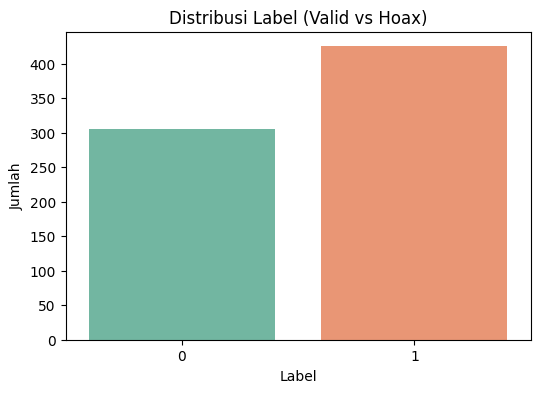

In [ ]:
# 7. Tambahkan panjang teks untuk analisis
df_cleaned['text_length'] = df_cleaned['Teks_Bersih'].apply(lambda x: len(x.split()))

## a. Distribusi Label
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='Label', hue='Label', palette='Set2', legend=False)
plt.title("Distribusi Label (Valid vs Hoax)")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

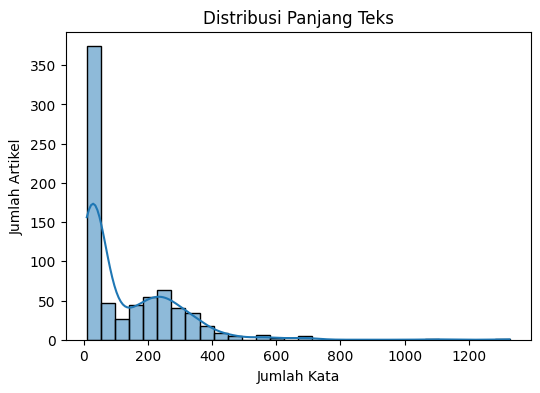

In [ ]:
## b. Panjang Teks
plt.figure(figsize=(6, 4))
sns.histplot(df_cleaned['text_length'], bins=30, kde=True)
plt.title("Distribusi Panjang Teks")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Artikel")
plt.show()

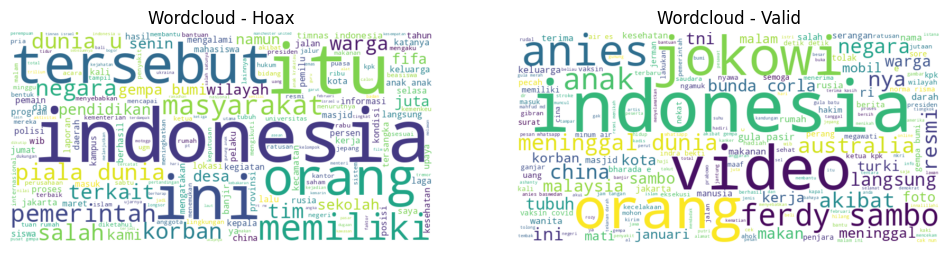

In [ ]:
# Daftar stopword Bahasa Indonesia
stopwords_ind = set(stopwords.words('indonesian') + ['yg', 'dgn', 'dr', 'sdh', 'sdg', 'utk', 'pd', 'sm', 'tp', 'jg', 'aja', 'krn',
    'wkwk', 'zzz', 'hmm', 'hehe', 'uh', 'loh', 'yah', 'ampun', 'pls', 'ok',
    'saya', 'kamu', 'kita', 'anda', 'mereka', 'dia', 'itu', 'ini', 'tersebut',
    'cepat', 'viral', 'heboh', 'waspada', 'ternyata', 'sebarkan', 'segera', 'penting',
    'dll', 'u', 'U', 'd', 'x', 'n', 'aa', 'ii', 'oe'])

# Fungsi menghapus stopword
def remove_stopwords(text):
    # Frasa penting yang ingin disatukan
    phrase_dict = {
        'virus corona': 'virus_corona',
        'covid 19': 'covid19',
        'corona virus': 'virus_corona',
        'presiden jokowi': 'presiden_jokowi'
        # tambah sesuai kebutuhan
    }
    text = text.lower()
    tokens = text.split()
    tokens_filtered = [word for word in tokens if word.lower() not in stopwords_ind]
    return ' '.join(tokens_filtered)

# Aplikasikan ke dataframe sebelum membuat WordCloud
df_cleaned['Teks_Tanpa_Stopword'] = df_cleaned['Teks_Bersih'].apply(remove_stopwords)

## c. Wordcloud
text_hoax = ' '.join(df_cleaned[df_cleaned['Label'] == 0]['Teks_Tanpa_Stopword'])
text_valid = ' '.join(df_cleaned[df_cleaned['Label'] == 1]['Teks_Tanpa_Stopword'])

wordcloud_hoax = WordCloud(width=800, height=400, background_color='white').generate(text_hoax)
wordcloud_valid = WordCloud(width=800, height=400, background_color='white').generate(text_valid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_hoax, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud - Hoax")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_valid, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud - Valid")
plt.show()

##**Split Train/Test Data**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_cleaned['Teks_Bersih']
y = df_cleaned['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Menampilkan hasil split
print("Jumlah data training:", len(X_train))
print("Jumlah data testing :", len(X_test))

Jumlah data training: 584
Jumlah data testing : 146


##**Feature Extraction**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-large-p1")

# Tokenisasi train dan test
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

import torch
from torch.utils.data import Dataset

class IndoBERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

train_dataset = IndoBERTDataset(train_encodings, list(y_train))
test_dataset = IndoBERTDataset(test_encodings, list(y_test))

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


##**Modeling**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-lite-large-p1", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    loop = tqdm(train_loader)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


Epoch 1: 100%|██████████| 73/73 [00:44<00:00,  1.65it/s, loss=0.0777]


Epoch 2


Epoch 2: 100%|██████████| 73/73 [00:41<00:00,  1.75it/s, loss=0.0114]


Epoch 3


Epoch 3: 100%|██████████| 73/73 [00:43<00:00,  1.70it/s, loss=0.0509]


Epoch 4


Epoch 4: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.0122]


Epoch 5


Epoch 5: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.00156]


Epoch 6


Epoch 6: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.000565]


Epoch 7


Epoch 7: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.0113]


Epoch 8


Epoch 8: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.00155]


Epoch 9


Epoch 9: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.00154]


Epoch 10


Epoch 10: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s, loss=0.000127]


##**Evaluasi Model IndoBERT**

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=["Valid (0)", "Hoax (1)"]))

              precision    recall  f1-score   support

   Valid (0)       1.00      1.00      1.00        61
    Hoax (1)       1.00      1.00      1.00        85

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



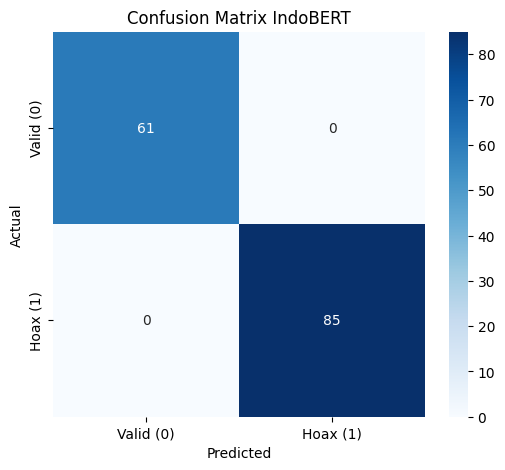

In [ ]:
# Hitung confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Buat label
labels = ["Valid (0)", "Hoax (1)"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix IndoBERT')
plt.show()

##**Menyimpan Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Direktori penyimpanan di Google Drive
save_directory = "/content/drive/MyDrive/Kuliah/Semester 6/PDM/Final Project/Model Ringan"

# Simpan model dan tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model dan tokenizer berhasil disimpan di Google Drive.")

Mounted at /content/drive
Model dan tokenizer berhasil disimpan di Google Drive.


##**Mengubah & Menyimpan Model Menjadi Onnx**

In [ ]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Load tokenizer dan model yang sudah dilatih
model_path = "/content/drive/MyDrive/Kuliah/Semester 6/PDM/Final Project/Model Ringan"  # Ganti dengan path model Anda
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 2. Set model ke eval mode
model.eval()

# 3. Buat input dummy
text = "Ini adalah berita palsu."  # Contoh kalimat
inputs = tokenizer(text, return_tensors="pt")

# 4. Ekspor ke ONNX
torch.onnx.export(
    model,
    (inputs["input_ids"], inputs["attention_mask"]),
    "/content/drive/MyDrive/Kuliah/Semester 6/PDM/Final Project/Model Onnx/indobert_fake_news.onnx",  # Simpan ONNX langsung ke Drive
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence"},
        "attention_mask": {0: "batch_size", 1: "sequence"},
        "logits": {0: "batch_size"}
    },
    opset_version=16,
    do_constant_folding=True
)

print("Model berhasil diekspor ke ONNX dan disimpan di Google Drive.")

Model berhasil diekspor ke ONNX dan disimpan di Google Drive.
